# What
Our code is a mess. This is just to not have to run everything all the time. Allows us to focus on the data we have instead of trying to get even more messy data.

This should be used as a default and copies should be done to build on top. The idea of this is that it's a basic AF readers so that actual analysis can be done.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import statistics
import math
import plotly.express as px

# networkx
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

# For semantic similarity
from urllib.parse import unquote
from transformers import BertTokenizer
from transformers import BertModel
from sklearn.metrics.pairwise import cosine_similarity

# Python functions in .py file to read data
import data_readers

import warnings
from tqdm import TqdmWarning
warnings.filterwarnings('ignore', category=TqdmWarning)

# Our custom plotting functions
import plot_functions

In [2]:
# The links and edges
wikispeedia = data_readers.read_wikispeedia_graph()

# The finished paths
finished_paths = data_readers.read_finished_paths()

# The unfinished paths
unfinished_paths = data_readers.read_unfinished_paths()

# DF of all articles and their categories
categories = data_readers.read_categories()

# Searching for the string of a given article. It has to be formatted like the article name
# Which shouldn't be a problem, as we'll probably usually retrieve them internally
obi_wan_text = data_readers.plaintext_article_finder('Obi-Wan_Kenobi')

source_target_info = data_readers.source_target_paths_information()

In [3]:
# This is a last step, of making these three datasets have consistent column names and order
# as well as guaranteeing that the index order is conistent with both elements
# Even though the boolean column is weird, it's a boolean so that's all good

# FUCK IT. We don't touch the decoded version, that's too painful!

col_names = ['source', 'target', 'reached', 'length', 'visited']

import ast

carlos_df = pd.read_csv('machine_outputs/data_carlos.csv')
carlos_df.columns = col_names

carlos_df['visited'] = carlos_df['visited'].str.strip('\\').str.strip('{}')
carlos_df['visited'] = carlos_df['visited'].apply(lambda x: ast.literal_eval(x))

semantic_rank_df = pd.read_csv('machine_outputs/carolOutput.csv')
semantic_rank_df.columns = col_names

semantic_rank_df['visited'] = semantic_rank_df['visited'].str.strip('\\').str.strip('{}')
semantic_rank_df['visited'] = semantic_rank_df['visited'].apply(lambda x: ast.literal_eval(x))

landmark_df = pd.read_csv('machine_outputs/landmark_method_results.csv')

# Landmark_df is the only one with substantive change
landmark_df.drop('Unnamed: 0', axis=1, inplace=True)
landmark_df['reached'] = True
landmark_df.columns = ['source', 'target', 'length', 'visited', 'reached']
landmark_df = landmark_df[col_names]
# Due to the way length was counted here, I need to update to increase by one
landmark_df['length'] = landmark_df['length'] + 1

landmark_df['visited'] = landmark_df['visited'].str.strip('\\').str.strip('{}')
landmark_df['visited'] = landmark_df['visited'].apply(lambda x: ast.literal_eval(x))
landmark_df = landmark_df.sort_values('source')

In [4]:
finished_paths = finished_paths[['first_article', 'last_article', 'path_length', 'path']]
finished_paths = finished_paths.rename(columns={'first_article':'source', 'last_article':'target', 'path_length':'length','path':'visted'})

Modify given datasets

In [5]:
unfinished_paths['source'] = unfinished_paths['path'].str.split(';').apply(lambda x: x[0])
unfinished_paths = unfinished_paths[['source', 'target', 'path', 'type']]


In [6]:
def add_category_of_target_article(df_to_add_category_to) -> pd.DataFrame:
    categories[categories['article'].duplicated()]
    categories['article'] = categories['article'].drop_duplicates()
    sub_categories = categories['categories'].str[8:].str.split('.')
    category_depth_1 = sub_categories.apply(lambda x: x[0])
    categories['category'] = category_depth_1

    new_df = pd.merge(df_to_add_category_to, categories, left_on = 'target', right_on= 'article', how = 'left')
    new_df = new_df.drop(columns = ['article', 'categories'])
    return new_df

finished_paths = add_category_of_target_article(finished_paths)
unfinished_paths = add_category_of_target_article(unfinished_paths)

landmark_df = add_category_of_target_article(landmark_df)
semantic_rank_df = add_category_of_target_article(semantic_rank_df)
carlos_df = add_category_of_target_article(carlos_df)

What are the most common finished, and unfinished paths?

In [7]:
def normalize_category_frequency_by_num_articles_they_have(paths_df, category_df = categories) -> pd.DataFrame:
    # Returns frequency of categories of target articles in finished/unfinished paths
    category_counts = paths_df['category'].value_counts()
    num_articles_per_category = categories.groupby('category')['article'].count()
    normalized_category_counts = category_counts / num_articles_per_category
    normalized_category_counts = normalized_category_counts.sort_values(ascending=False)
    return normalized_category_counts

normalized_category_counts_finished = normalize_category_frequency_by_num_articles_they_have(finished_paths)
normalized_category_counts_unfinished = normalize_category_frequency_by_num_articles_they_have(unfinished_paths)

In [8]:
plot_functions.barplot_solo(normalized_category_counts_finished, file_name= 'normalized_category_counts_finished', title = "Normalized Frequency of Categories of Target Articles in Finished Paths", color = 'red')
plot_functions.barplot_solo(normalized_category_counts_unfinished, file_name= 'normalized_category_counts_unfinished', title = "Normalized Frequency of Categories of Target Articles in Unfinished Paths", color = 'blue')


In [150]:
finished_paths

source                  target  \
0                                    14th_century     African_slave_trade   
1                                    14th_century     African_slave_trade   
2                                    14th_century     African_slave_trade   
3                                    14th_century                  Greece   
4                                    14th_century         John_F._Kennedy   
...                                           ...                     ...   
51313                                       Yagan            Civilization   
51314                                       Yagan                 Fiction   
51315                                       Yagan  U.S._Open_%28tennis%29   
51316  Yarralumla%2C_Australian_Capital_Territory         Abraham_Lincoln   
51317                                 Ziad_Jarrah                     Jew   

       length                                             visted  \
0           9  14th_century;15th_century;16th_century;Pacific...   
1           5  14th_century;Europe;Africa;Atlantic_slave_trad...   
2           8  14th_century;Niger;Nigeria;British_Empire;Slav...   
3           4     14th_century;Renaissance;Ancient_Greece;Greece   
4           7  14th_century;Italy;Roman_Catholic_Church;HIV;R...   
...       ...                                                ...   
51313       3                   Yagan;Ancient_Egypt;Civilization   
51314       9  Yagan;Folklore;Brothers_Grimm;<;19th_century;C...   
51315       7  Yagan;Australia;England;France;United_States;T...   
51316       4  Yarralumla%2C_Australian_Capital_Territory;Aus...   
51317       3                            Ziad_Jarrah;Germany;Jew   

                      category  
0                      History  
1                      History  
2                      History  
3                    Countries  
4                       People  
...                        ...  
51313              Citizenship  
51314  Language_and_literature  
51315            Everyday_life  
51316                   People  
51317                Geography  

[51318 rows x 5 columns]

When are human paths shorter than the machine paths?

In [9]:
def combine_human_and_machine(df_human, df_machine) -> pd.DataFrame:
    df = pd.merge(df_human, df_machine, how = 'inner', left_on= ['first_article', 'last_article'], right_on = ['Source', 'Target'])
    df.rename(columns= {'path_length': 'man_len', 'len_shortest_path': 'machine_len'}, inplace=True)
    return df

In [10]:
a = finished_paths.groupby('category')['length'].mean()
b = landmark_df.groupby('category')['length'].mean()
c = semantic_rank_df.groupby('category')['length'].mean()
d = carlos_df.groupby('category')['length'].mean()

avg_lengths_df = pd.DataFrame((a,b,c, d)).T
avg_lengths_df.columns = ['human', 'landmark', 'semantic_rank', 'carlos']
avg_lengths_df = avg_lengths_df.sort_values('human')

plot_functions.barplot_groups(avg_lengths_df, file_name= 'avg_lengths', title='Average Finished Path Length by Category of Machine vs Man', barmode='group')

In [ ]:
def add_category_of_target_article(df_to_add_category_to) -> pd.DataFrame:
    categories[categories['article'].duplicated()]
    categories['article'] = categories['article'].drop_duplicates()
    sub_categories = categories['categories'].str[8:].str.split('.')
    category_depth_1 = sub_categories.apply(lambda x: x[0])
    categories['category'] = category_depth_1

    new_df = pd.merge(df_to_add_category_to, categories, left_on = 'target', right_on= 'article', how = 'left')
    new_df = new_df.drop(columns = ['article', 'categories'])
    return new_df

In [19]:
source_target_info.columns

Index(['first_article', 'last_article', 'count', 'mean_length', 'std_length',
       'mean_rating', 'std_rating', 'mean_durationInSec', 'std_durationInSec'],
      dtype='object')

## Analyzing the frequency of lengths

Text(0.5, 1.0, 'Frequency of Landmark Approach')

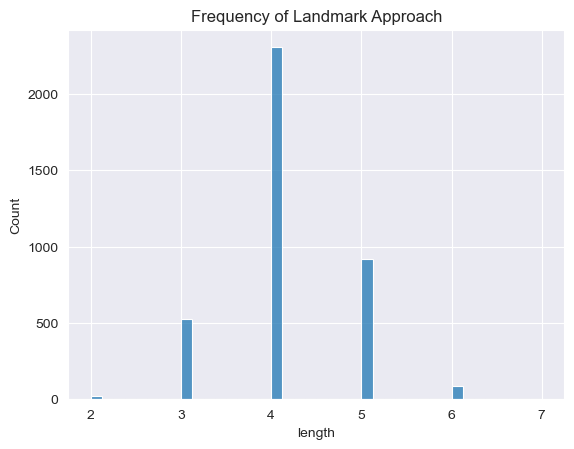

In [15]:
sns.histplot(data=landmark_df, x='length')
plt.title('Histogram of lengths for Landmark Approach')

Text(0.5, 1.0, 'Histogram of lengths for SemanticRank Approach')

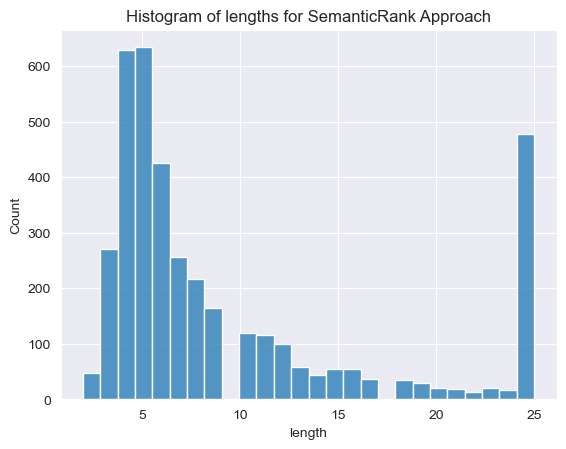

In [22]:
sns.histplot(data=semantic_rank_df, x='length')
plt.title('Histogram of lengths for SemanticRank Approach')

In [23]:
finished_paths.columns

Index(['source', 'target', 'length', 'visted', 'category'], dtype='object')

Text(0.5, 1.0, 'Histogram of lengths for human data')

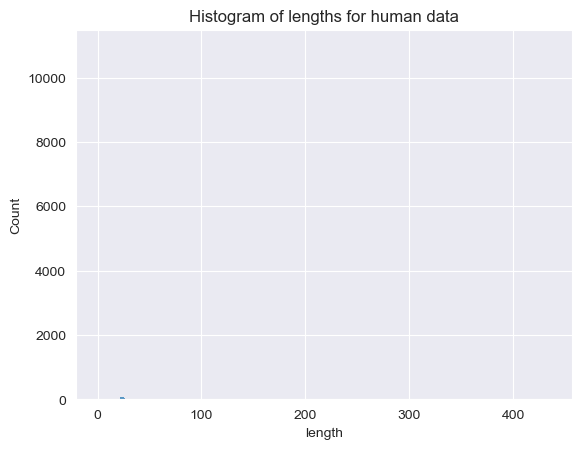

In [25]:
sns.histplot(data=finished_paths, x='length')
plt.title('Histogram of lengths for human data')

In [26]:
finished_paths.sort_values(by='length', ascending=False)

source                 target  length  \
8046          United_States       English_language     435   
19961  Napoleon_I_of_France              Recycling     119   
6945           Police_state    African_slave_trade     104   
27136             Lake_Toba           Looney_Tunes      99   
22845        Britney_Spears  Extraterrestrial_life      96   
...                     ...                    ...     ...   
23347                 Apple                  Apple       1   
50466      William_and_Mary       William_and_Mary       1   
33832           Abel_Tasman            Abel_Tasman       1   
9872                   Coal                   Coal       1   
30761            Royal_Navy             Royal_Navy       1   

                                                  visted  \
8046   United_States;Washington%2C_D.C.;Government;Co...   
19961  Napoleon_I_of_France;United_Kingdom;Great_Brit...   
6945   Police_state;Police;United_States;Washington%2...   
27136  Lake_Toba;Netherlands;Europe;Earth;United_Stat...   
22845  Britney_Spears;Las_Vegas%2C_Nevada;<;Las_Vegas...   
...                                                  ...   
23347                                              Apple   
50466                                   William_and_Mary   
33832                                        Abel_Tasman   
9872                                                Coal   
30761                                         Royal_Navy   

                      category  
8046   Language_and_literature  
19961              Citizenship  
6945                   History  
27136            Everyday_life  
22845                  Science  
...                        ...  
23347            Everyday_life  
50466                  History  
33832                   People  
9872               Citizenship  
30761                  History  

[51318 rows x 5 columns]

In [34]:
(finished_paths['length'] >= 25).sum()

432

Text(0.5, 1.0, 'Histogram of lengths for human data')

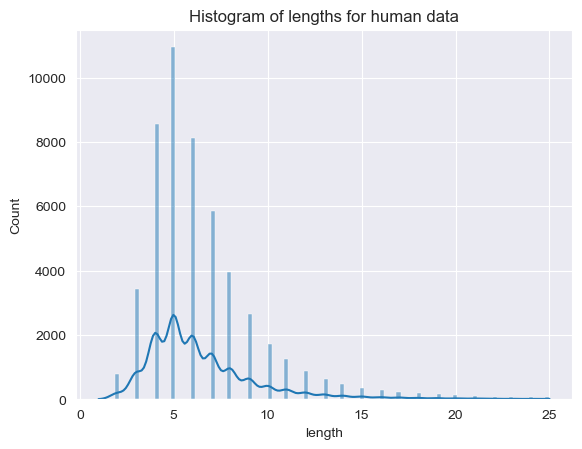

In [35]:
trimmed_finished = finished_paths[finished_paths['length'] <= 25]

sns.histplot(data=trimmed_finished, x='length', kde=True)
plt.title('Histogram of lengths for human data')

In [149]:
# This is separate because it takes a while to run
shortest_paths = dict(nx.all_pairs_shortest_path_length(wikispeedia))

In [147]:
# Now, just go through the paths and store the values in a list...
# I'll assume everything is in landmark_df, just to make things easier
optimal_shortest_paths = []

for index, row in landmark_df.iterrows():
    # We have to do plus one because of how we measure distance on the other methods
    optimal_shortest_paths.append(shortest_paths[row['source']][row['target']] + 1)

Text(0.5, 1.0, 'Histogram of lengths for optimal values')

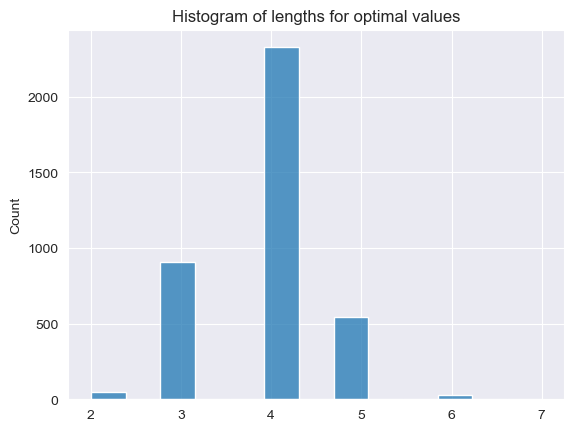

In [148]:
sns.histplot(data=optimal_shortest_paths)
plt.title('Histogram of lengths for optimal values')

## Trying to characterize paths

I wanna see if I can characterize the paths. This shit is painful, as we have to try and deal with the different elements. 

Most intuitive solution I could think of is getting the average embedding, do TSNE afterwards, and do a nice plot with color representing the lengths.

In [47]:
# Imports needed to get the embeddings
from sentence_transformers import SentenceTransformer
import torch
model = SentenceTransformer('all-MiniLM-L6-v2')

def decode_word(word):
    word = word.replace('_', ' ')
    return unquote(word)

# Function to get embeddings using sentence transformer
def get_embedding(text):
    return model.encode(decode_word(text), convert_to_tensor=True)

# Function to perform L2 normalization on the embeddings
def l2_normalize(tensor):
    return tensor / tensor.norm(p=2, dim=0, keepdim=True)

# Function to calculate semantic similarity between two pieces of text
def semantic_similarity(word1, word2):
    embedding1 = get_embedding(word1)
    embedding2 = get_embedding(word2)

    # L2 normalization of the embeddings (to make sure, although embedding should already be normalized)
    embedding1_normalized = l2_normalize(embedding1)
    embedding2_normalized = l2_normalize(embedding2)

    # Compute and return the similarity of normalized tensors
    return torch.dot(embedding1_normalized, embedding2_normalized).item()

def get_mean_embeddings(elem_list: list) -> torch.tensor:
    result = get_embedding(elem_list[0])

    for i in range(1, len(elem_list)-1):
        result += get_embedding(elem_list[i])
    return result/len(elem_list)

In [70]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def get_tsne_mean_embedding_of_path(input: pd.DataFrame) -> pd.DataFrame:
    mean_embedding = input['visited'].apply(get_mean_embeddings)
    
    temp = torch.zeros((input.shape[0], 384))
    for i in range(len(mean_embedding)-1):
        temp[i] = mean_embedding[i]

    tsne = TSNE()

    tsne_input = tsne.fit_transform(temp)
    
    # Need to expand the dimension of input length so the concatenation works out
    temp_test = np.concatenate([tsne_input, np.expand_dims(input['length'].values, 1)], axis=1)
    df = pd.DataFrame(temp_test, columns=['Feature 1', 'Feature 2', 'Length'])
    
    return df

In [71]:
semantic_rank_tsne_df = get_tsne_mean_embedding_of_path(semantic_rank_df)
landmark_tsne_df = get_tsne_mean_embedding_of_path(landmark_df)

Text(0.5, 1.0, 'Semantic Rank Mean Embedding TSNE and Length')

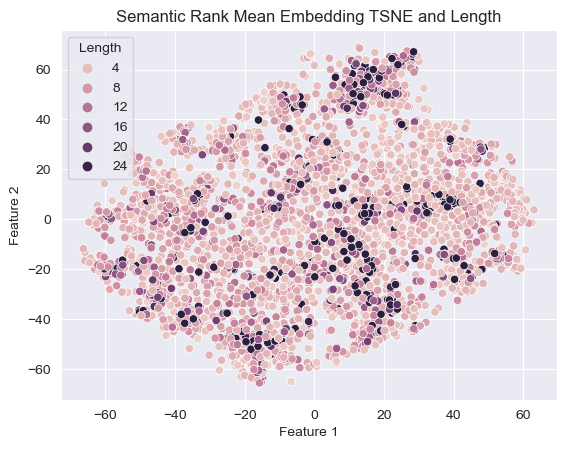

In [72]:
sns.scatterplot(data=semantic_rank_tsne_df, x='Feature 1', y='Feature 2', hue='Length')
plt.title('Semantic Rank Mean Embedding TSNE and Length')

Text(0.5, 1.0, 'Landmark TSNE and Length')

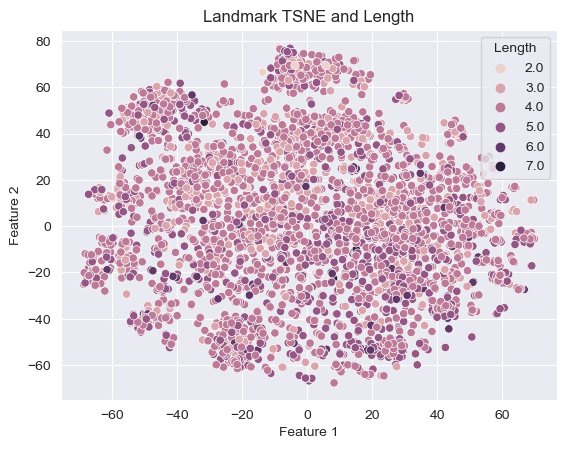

In [73]:
sns.scatterplot(data=landmark_tsne_df, x='Feature 1', y='Feature 2', hue='Length')
plt.title('Landmark TSNE and Length')

In [78]:
# Now, just go through the paths and store the values in a list...
# I'll assume everything is in landmark_df, just to make things easier
shortest_paths_themselves = []

for index, row in landmark_df.iterrows():
    shortest_paths_themselves.append(nx.shortest_path(wikispeedia, row['source'], row['target']))

temp = torch.zeros((landmark_df.shape[0], 384))
for i in range(landmark_df.shape[0]-1):
    temp[i] = get_mean_embeddings(shortest_paths_themselves[i])

tsne = TSNE()
tsne_input = tsne.fit_transform(temp)

lengths_optimal = [len(item) for item in shortest_paths_themselves]

lengths_optimal = np.expand_dims(np.array(lengths_optimal), 1)

# Need to expand the dimension of input length so the concatenation works out
temp_test = np.concatenate([tsne_input, lengths_optimal], axis=1)
df = pd.DataFrame(temp_test, columns=['Feature 1', 'Feature 2', 'Length'])

Text(0.5, 1.0, 'Optimal TSNE and Length')

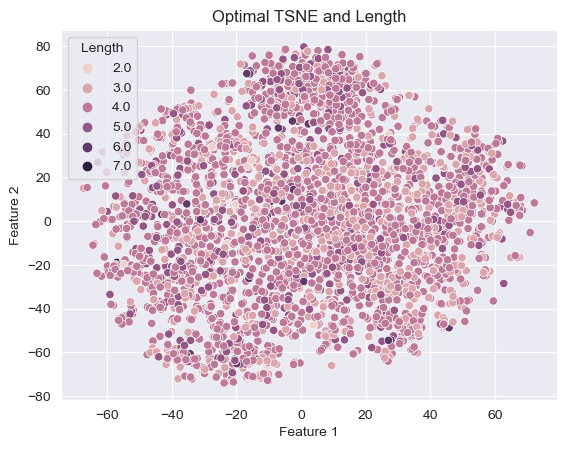

In [83]:
sns.scatterplot(data=df, x='Feature 1', y='Feature 2', hue='Length')
plt.title('Optimal TSNE and Length')

In [95]:
# This shit takes forever to run, no fucking surprise. If someone can do this for me
# I'd give them kisses and love
trimmed_finished = finished_paths.loc[finished_paths['length'] <= 25, :]

trimmed_finished.columns = ['source', 'target', 'length', 'visited', 'category']
trimmed_finished.loc[:, 'visited'] = trimmed_finished['visited'].str.split(';')

human_tsne_df = get_tsne_mean_embedding_of_path(trimmed_finished)

sns.scatterplot(data=human_tsne_df, x='Feature 1', y='Feature 2', hue='Length')
plt.title('Semantic Rank Mean Embedding TSNE and Length')

C:\Users\nicol\AppData\Local\Temp\ipykernel_13848\1661221281.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyboardInterrupt: 

Can machine do some of the unfinished paths that man couldn’t?

We'll only focus on the ones that happened by restart, as those are the most relevant ones.

Additionally, because we only care about whether it's achievable or not, we will only focus on whether a path was found or not.


In [114]:
only_relevant_paths = unfinished_paths[unfinished_paths['type'] == 'restart']

unique_unfinished_paths = only_relevant_paths.groupby(['source','target']).size().reset_index().rename(columns={0:'count'})

import machine_searchers

landmark_method = machine_searchers.LandmarkSearch(wikispeedia)
semantic_rank_method = machine_searchers.AlgorithmCarol(wikispeedia)


In [115]:
unique_unfinished_paths.shape

(11648, 3)

In [118]:
# This shit takes forever to run, no fucking surprise. If someone can do this for me
# I'd give them kisses and love
import time

landmark_res = []
semantic_rank_res = []

not_found_landmark = []
not_found_semantic_rank = []

for index, row in unique_unfinished_paths.iterrows():
    try:
        # If it's not a key, by default I'll assume it's false
        # So if this works it's just true
        _ = landmark_method.find_shortest_path(row['source'], row['target'])
        landmark_res.append(True)
    except:
        landmark_res.append(False)
        not_found_landmark.append((row['source'], row['target']))
        
    # start_time = time.time()
    # _, _, _, path_length, _ = semantic_rank_method.find_shortest_path(wikispeedia, row['source'], row['target'])
    # end_time = time.time()
    # 
    # print('Took:', end_time-start_time, "to finish one run")
    # 
    # if index % 50 == 0:
    #     print('Finished', index)
    # 
    # if path_length < 25:
    #     semantic_rank_res.append(True)
    # else:
    #     semantic_rank_res.append(False)
    #     not_found_semantic_rank.append((row['source'], row['target']))


In [119]:
print("Landmark has following percent found: ", np.array(landmark_res).sum()/len(landmark_res))
#print("SemanticRank has following percent found: ", np.array(semantic_rank_res).sum()/len(semantic_rank_res))

Landmark has following percent found:  0.9978537087912088


In [120]:
print("Unfound for Landmark are:")
print(not_found_landmark)

Unfound for Landmark are:
[('Andrew_Jackson', 'Christmas'), ('Anne_Frank', 'Final_Fantasy_%28video_game%29'), ('Beijing', 'Usa'), ('Bird', 'Great'), ('Black_pepper', 'Long_peper'), ('Coin', 'Macedonia'), ('Diamond', 'The_Rock'), ('England', 'English'), ('Europe', 'Rat'), ('Europe', 'The'), ('Food', 'Fats'), ('Hymenoptera', 'Portuguese_Communist_Party'), ('Lavender', 'Charlottes_web'), ('Marco_Polo', 'Netbook'), ('Meteor', 'Rss'), ('Music', 'Sportacus'), ('Oasis_%28band%29', 'Final_Fantasy_%28video_game%29'), ('Pakistan', 'Kashmir'), ('Star_Trek', 'Test'), ('Switzerland', 'Christmas'), ('Theatre', '_Zebra'), ('Tripoli', 'Bogota'), ('Walrus', 'Black_ops_2'), ('Watercolor_painting', 'Podcast'), ('World_War_II', 'Adolph_Hitler')]


Could only run for landmark in time, but now I wanna search, why? Is it possible that these nodes just aren't reachable?

For this, I'll assume that networkX takes care of everything

In [122]:
shortest_path_for_unfound = []

not_found_at_all = []

for elem in not_found_landmark:
    try:
        shortest_path_for_unfound.append(shortest_paths[elem[0]][elem[1]])
    except KeyError:
        not_found_at_all.append(elem)

In [124]:
shortest_path_for_unfound

[]

So, none of the elements are in the shortest path dictionary... we'll check manually the tsv file.

Printing the names to see them right now:

In [125]:
not_found_at_all

[('Andrew_Jackson', 'Christmas'),
 ('Anne_Frank', 'Final_Fantasy_%28video_game%29'),
 ('Beijing', 'Usa'),
 ('Bird', 'Great'),
 ('Black_pepper', 'Long_peper'),
 ('Coin', 'Macedonia'),
 ('Diamond', 'The_Rock'),
 ('England', 'English'),
 ('Europe', 'Rat'),
 ('Europe', 'The'),
 ('Food', 'Fats'),
 ('Hymenoptera', 'Portuguese_Communist_Party'),
 ('Lavender', 'Charlottes_web'),
 ('Marco_Polo', 'Netbook'),
 ('Meteor', 'Rss'),
 ('Music', 'Sportacus'),
 ('Oasis_%28band%29', 'Final_Fantasy_%28video_game%29'),
 ('Pakistan', 'Kashmir'),
 ('Star_Trek', 'Test'),
 ('Switzerland', 'Christmas'),
 ('Theatre', '_Zebra'),
 ('Tripoli', 'Bogota'),
 ('Walrus', 'Black_ops_2'),
 ('Watercolor_painting', 'Podcast'),
 ('World_War_II', 'Adolph_Hitler')]

In [138]:
shortest_path_for_unfound = []

no_path_between_nodes = []
node_not_in_graph = []
both_nodes_missing = []

for elem in not_found_landmark:
    try:
        shortest_path_for_unfound.append(nx.shortest_path(wikispeedia, elem[0], elem[1]))
    except:
        # So now, we check if either of the nodes doesn't exist
        # If they both exist, then there is just no path
        if (not elem[0] in wikispeedia) or (not elem[1] in wikispeedia):
            if not elem[0] in wikispeedia:
                node_not_in_graph.append(elem[0])
            if not elem[1] in wikispeedia:
                node_not_in_graph.append(elem[1])
            if (not elem[0] in wikispeedia) and (not elem[1] in wikispeedia):
                both_nodes_missing.append(elem)
        else:
            no_path_between_nodes.append(elem)

In [139]:
both_nodes_missing

[]

In [136]:
node_not_in_graph

['Christmas',
 'Usa',
 'Great',
 'Long_peper',
 'Macedonia',
 'The_Rock',
 'English',
 'Rat',
 'The',
 'Fats',
 'Charlottes_web',
 'Netbook',
 'Rss',
 'Sportacus',
 'Kashmir',
 'Test',
 'Christmas',
 '_Zebra',
 'Bogota',
 'Black_ops_2',
 'Podcast',
 'Adolph_Hitler']

In [137]:
no_path_between_nodes

[('Anne_Frank', 'Final_Fantasy_%28video_game%29'),
 ('Hymenoptera', 'Portuguese_Communist_Party'),
 ('Oasis_%28band%29', 'Final_Fantasy_%28video_game%29')]

So, it's always the case that one of the nodes is missing. 

Based on the names, sometimes this is caused because of typos, IE Usa not being United_States, same with peper.

The really interesting ones are the ones with no_path_between_nodes, because that means there was actually no path. Let's assume that it is because there's no outgoing or incoming nodes to one of these

In [143]:
for elem in no_path_between_nodes:
    print('Successors of:', elem[0], 'are:', list(wikispeedia.successors(elem[0])))
    print('Predecessors of:', elem[1], 'are:', list(wikispeedia.predecessors(elem[1])))
#list(wikispeedia.successors('Anne_Frank'))

Successors of: Anne_Frank are: ['Aachen', 'Adolf_Hitler', 'Amsterdam', 'Arithmetic', 'Basel', 'Dallas%2C_Texas', 'Drama', 'Dutch_language', 'Employment', 'Fascism', 'Film', 'Frankfurt', 'Germany', 'God', 'Hamburg', 'Humanism', 'India', 'Israel', 'Jew', 'Johannesburg', 'Judaism', 'Nationality', 'Nazism', 'Nelson_Mandela', 'Netherlands', 'New_York_City', 'Opera', 'Philadelphia', 'Publishing', 'Roman_Catholic_Church', 'Rwanda', 'Sarajevo', 'Slavery', 'Somalia', 'Soviet_Union', 'Switzerland', 'Television', 'The_Holocaust', 'Theatre', 'United_Kingdom', 'United_States', 'Vienna', 'Washington%2C_D.C.', 'World_War_II']
Predecessors of: Final_Fantasy_%28video_game%29 are: ['Final_Fantasy_Adventure']
Successors of: Hymenoptera are: ['Animal', 'Ant', 'Arthropod', 'Bee', 'Carolus_Linnaeus', 'Cretaceous', 'Insect', 'Scientific_classification', 'Thorax', 'Triassic', 'Wasp']
Predecessors of: Portuguese_Communist_Party are: ['History_of_the_Portuguese_Communist_Party']
Successors of: Oasis_%28band%29 

Okay, so it seems that there's issues with incoming from Final_Fantasy_Adventure and from History_of_the_Portuguese_Communist_Party. Let's check their predecessors!

In [145]:
print(list(wikispeedia.predecessors('Final_Fantasy_Adventure')))
print(list(wikispeedia.predecessors('History_of_the_Portuguese_Communist_Party')))

[]
['Portuguese_Communist_Party']


Okay, this means the two nodes where there were no paths, are nodes that aren't connected to the rest of the graph, or are nodes that don't exist. Which means in reality that our system was able to find the elements perfectly!